# Black Hole Mass Estimation


###### 
This is a notebook to calculate the black hole mass given the spectrum and 
using PyQSO ability to measure the full width at half maximum (FWHM) of H${{\alpha}}$


Packages Used:
- PyQSO
- DESI (`desispec`)
- Astropy
- Matplotlib
- Numpy


In [2]:
import desispec.io                             # Input/Output functions related to DESI spectra
from desispec import coaddition                # Functions related to coadding the spectra

# import some helpful python packages 
import os
import numpy as np

from astropy.io import fits
from astropy.convolution import convolve, Gaussian1DKernel
from astropy.table import Table
import matplotlib 
import matplotlib.pyplot as plt

In [3]:
# Release directory path

specprod = 'fuji'    # Internal name for the EDR
specprod_dir = '/global/cfs/cdirs/desi/public/edr/spectro/redux/fuji'

In [4]:

zpix_cat = Table.read(f'{specprod_dir}/zcatalog/zall-pix-{specprod}.fits', hdu="ZCATALOG")

In [5]:
sel = (zpix_cat['ZCAT_NSPEC'] >= 1)
targets = zpix_cat[sel]['TARGETID']

zpix_cat['Z'][2261376]

## Selecting random TARGETID from these targets
ii = 2261376
targetid = targets[ii]

# Selecting the redshift catalogs rows for the particular targetid
rows = zpix_cat['TARGETID'] == targetid
zcat_sel = zpix_cat[rows]

healpix_dir = f'{specprod_dir}/healpix'

# Defining healpix, survey, and program variables for this target

survey_col = zcat_sel['SURVEY'].astype(str)
program_col = zcat_sel['PROGRAM'].astype(str)
hpx_col = zcat_sel['HEALPIX']

# Selecting the primary spectra - 
is_primary = zcat_sel['ZCAT_PRIMARY']

# Information needed to access the spectra 
survey = survey_col[is_primary][0]
program = program_col[is_primary][0]
hpx = hpx_col[is_primary][0]    ## This is same for all the rows, given its the same TARGET. But, just to be consistent.

# Let us explore the target directory
# Note that the target directory is different for the different spectra.
# We first explore the primary spectra and look at the other spectra later.
tgt_dir = f'{healpix_dir}/{survey}/{program}/{hpx//100}/{hpx}'

# Filename - 
coadd_filename = f'coadd-{survey}-{program}-{hpx}.fits'
coadd_obj = desispec.io.read_spectra(f'{tgt_dir}/{coadd_filename}')
coadd_tgts = coadd_obj.target_ids().data
row = (coadd_tgts == targetid)
coadd_spec = coadd_obj[row]
# Combined Spectra - 

spec_combined = coaddition.coadd_cameras(coadd_spec)

INFO:spectra.py:291:read_spectra: iotime 9.728 sec to read coadd-sv3-dark-10401.fits at 2024-05-30T17:35:29.738174


## Load in Packages for PyQSO
The spectra was loaded in! Now the next step is to use Pyqso to to fit to the emission \
lines of the object then pull the FWHM from one of its outputs

In [6]:
#%matplotlib inline
#%matplotlib widget
import glob, os, sys, timeit

sys.path.append('../')
from pyqsofit.PyQSOFit import QSOFit
import warnings

warnings.filterwarnings("ignore")

QSOFit.set_mpl_style()

In [7]:

import lmfit
import pyqsofit


print(lmfit.__version__)
print(pyqsofit.__version__)

import emcee  # optional, for MCMC

print(emcee.__version__)

1.2.2
2.0.0
3.1.4


In [8]:
path_ex = '.' #os.path.join(pyqsofit.__path__[0], '..', 'example')

# create a header
hdr0 = fits.Header()
hdr0['Author'] = 'Hengxiao Guo'
primary_hdu = fits.PrimaryHDU(header=hdr0)

In [9]:
"""
In this table, we specify the priors / initial conditions and boundaries for the line fitting parameters.
"""

line_priors = np.rec.array([
    (6564.61, 'Ha', 6400, 6800, 'Ha_br', 2, 0.0, 0.0, 1e10, 5e-3, 0.004, 0.05, 0.015, 0, 0, 0, 0.05, 1),
    (6564.61, 'Ha', 6400, 6800, 'Ha_na', 1, 0.0, 0.0, 1e10, 1e-3, 5e-4, 0.00169, 0.01, 1, 1, 0, 0.002, 1),
    (6549.85, 'Ha', 6400, 6800, 'NII6549', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169, 5e-3, 1, 1, 1, 0.001, 1),
    (6585.28, 'Ha', 6400, 6800, 'NII6585', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169, 5e-3, 1, 1, 1, 0.003, 1),
    (6718.29, 'Ha', 6400, 6800, 'SII6718', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169, 5e-3, 1, 1, 2, 0.001, 1),
    (6732.67, 'Ha', 6400, 6800, 'SII6732', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169, 5e-3, 1, 1, 2, 0.001, 1),

    (4862.68, 'Hb', 4640, 5100, 'Hb_br', 2, 0.0, 0.0, 1e10, 5e-3, 0.004, 0.05, 0.01, 0, 0, 0, 0.01, 1),
    (4862.68, 'Hb', 4640, 5100, 'Hb_na', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169, 0.01, 1, 1, 0, 0.002, 1),
    (4960.30, 'Hb', 4640, 5100, 'OIII4959c', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169, 0.01, 1, 1, 0, 0.002, 1),
    (5008.24, 'Hb', 4640, 5100, 'OIII5007c', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169, 0.01, 1, 1, 0, 0.004, 1),
    (4960.30, 'Hb', 4640, 5100, 'OIII4959w',   1, 0.0, 0.0, 1e10, 3e-3, 2.3e-4, 0.004,  0.01,  2, 2, 0, 0.001, 1),
    (5008.24, 'Hb', 4640, 5100, 'OIII5007w',   1, 0.0, 0.0, 1e10, 3e-3, 2.3e-4, 0.004,  0.01,  2, 2, 0, 0.002, 1),
    #(4687.02, 'Hb', 4640, 5100, 'HeII4687_br', 1, 0.0, 0.0, 1e10, 5e-3, 0.004,  0.05,   0.005, 0, 0, 0, 0.001, 1),
    #(4687.02, 'Hb', 4640, 5100, 'HeII4687_na', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169, 0.005, 1, 1, 0, 0.001, 1),

    #(3934.78, 'CaII', 3900, 3960, 'CaII3934' , 2, 0.0, 0.0, 1e10, 1e-3, 3.333e-4, 0.00169, 0.01, 99, 0, 0, -0.001, 1),

    #(3728.48, 'OII', 3650, 3800, 'OII3728', 1, 0.0, 0.0, 1e10, 1e-3, 3.333e-4, 0.00169, 0.01, 1, 1, 0, 0.001, 1),

    #(3426.84, 'NeV', 3380, 3480, 'NeV3426',    1, 0.0, 0.0, 1e10, 1e-3, 3.333e-4, 0.00169, 0.01, 0, 0, 0, 0.001, 1),
    #(3426.84, 'NeV', 3380, 3480, 'NeV3426_br', 1, 0.0, 0.0, 1e10, 5e-3, 0.0025,   0.02,   0.01, 0, 0, 0, 0.001, 1),

    (2798.75, 'MgII', 2700, 2900, 'MgII_br', 2, 0.0, 0.0, 1e10, 5e-3, 0.004, 0.05, 0.015, 0, 0, 0, 0.05, 1),
    (2798.75, 'MgII', 2700, 2900, 'MgII_na', 1, 0.0, 0.0, 1e10, 1e-3, 5e-4, 0.00169, 0.01, 1, 1, 0, 0.002, 1),

    (1908.73, 'CIII', 1700, 1970, 'CIII_br', 2, 0.0, 0.0, 1e10, 5e-3, 0.004, 0.05, 0.015, 99, 0, 0, 0.01, 1),
    #(1908.73, 'CIII', 1700, 1970, 'CIII_na',   1, 0.0, 0.0, 1e10, 1e-3, 5e-4,  0.00169, 0.01,  1, 1, 0, 0.002, 1),
    #(1892.03, 'CIII', 1700, 1970, 'SiIII1892', 1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.003, 1, 1, 0, 0.005, 1),
    #(1857.40, 'CIII', 1700, 1970, 'AlIII1857', 1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.003, 1, 1, 0, 0.005, 1),
    #(1816.98, 'CIII', 1700, 1970, 'SiII1816',  1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.01,  1, 1, 0, 0.0002, 1),
    #(1786.7,  'CIII', 1700, 1970, 'FeII1787',  1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.01,  1, 1, 0, 0.0002, 1),
    #(1750.26, 'CIII', 1700, 1970, 'NIII1750',  1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.01,  1, 1, 0, 0.001, 1),
    #(1718.55, 'CIII', 1700, 1900, 'NIV1718',   1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.01,  1, 1, 0, 0.001, 1),

    (1549.06, 'CIV', 1500, 1700, 'CIV_br', 2, 0.0, 0.0, 1e10, 5e-3, 0.004, 0.05, 0.015, 0, 0, 0, 0.05, 1),
    # (1549.06, 'CIV', 1500, 1700, 'CIV_na', 1, 0.0, 0.0, 1e10, 1e-3, 5e-4, 0.00169, 0.01, 1, 1, 0, 0.002, 1),
    #(1640.42, 'CIV', 1500, 1700, 'HeII1640',    1, 0.0, 0.0, 1e10, 1e-3, 5e-4,   0.00169, 0.008, 1, 1, 0, 0.002, 1),
    #(1663.48, 'CIV', 1500, 1700, 'OIII1663',    1, 0.0, 0.0, 1e10, 1e-3, 5e-4,   0.00169, 0.008, 1, 1, 0, 0.002, 1),
    #(1640.42, 'CIV', 1500, 1700, 'HeII1640_br', 1, 0.0, 0.0, 1e10, 5e-3, 0.0025, 0.02,   0.008, 1, 1, 0, 0.002, 1),
    #(1663.48, 'CIV', 1500, 1700, 'OIII1663_br', 1, 0.0, 0.0, 1e10, 5e-3, 0.0025, 0.02,   0.008, 1, 1, 0, 0.002, 1),

    #(1402.06, 'SiIV', 1290, 1450, 'SiIV_OIV1', 1, 0.0, 0.0, 1e10, 5e-3, 0.002, 0.05,  0.015, 1, 1, 0, 0.05, 1),
    #(1396.76, 'SiIV', 1290, 1450, 'SiIV_OIV2', 1, 0.0, 0.0, 1e10, 5e-3, 0.002, 0.05,  0.015, 1, 1, 0, 0.05, 1),
    #(1335.30, 'SiIV', 1290, 1450, 'CII1335',   1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015, 0.01,  1, 1, 0, 0.001, 1),
    #(1304.35, 'SiIV', 1290, 1450, 'OI1304',    1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015, 0.01,  1, 1, 0, 0.001, 1),

    (1215.67, 'Lya', 1150, 1290, 'Lya_br', 3, 0.0, 0.0, 1e10, 5e-3, 0.002, 0.05, 0.02, 0, 0, 0, 0.05, 1),
    (1240.14, 'Lya', 1150, 1290, 'NV1240', 1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.01, 0.005, 0, 0, 0, 0.002, 1),
    # (1215.67, 'Lya', 1150, 1290, 'Lya_na', 1, 0.0, 0.0, 1e10, 1e-3, 5e-4, 0.00169, 0.01, 0, 0, 0, 0.002, 1),
    (1215.67, 'Lya', 1150, 1290, 'Lya_br', 1, 0.0, 0.0, 1e10, 5e-3, 0.002, 0.05, 0.02, 0, 0, 0, 0.05, 1),
    (1240.14, 'Lya', 1150, 1290, 'NV1240', 1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.01, 0.005, 0, 0, 0, 0.002, 1),
    (1215.67, 'Lya', 1150, 1290, 'Lya_na', 1, 0.0, 0.0, 1e10, 1e-3, 5e-4, 0.00169, 0.01, 0, 0, 0, 0.002, 1),
    ],

    formats='float32,    a20,  float32, float32,      a20,  int32, float32, float32, float32, float32, float32, float32, float32,   int32,  int32,  int32, float32, int32',
    names=' lambda, compname,   minwav,  maxwav, linename, ngauss,  inisca,  minsca,  maxsca,  inisig,  minsig,  maxsig,    voff,  vindex, windex, findex,  fvalue,  vary')

# Header
hdr1 = fits.Header()
hdr1['lambda'] = 'Vacuum Wavelength in Ang'
hdr1['minwav'] = 'Lower complex fitting wavelength range'
hdr1['maxwav'] = 'Upper complex fitting wavelength range'
hdr1['ngauss'] = 'Number of Gaussians for the line'

# Can be set to negative for absorption lines if you want
hdr1['inisca'] = 'Initial guess of line scale [flux]'
hdr1['minsca'] = 'Lower range of line scale [flux]'
hdr1['maxsca'] = 'Upper range of line scale [flux]'

hdr1['inisig'] = 'Initial guess of linesigma [lnlambda]'
hdr1['minsig'] = 'Lower range of line sigma [lnlambda]'
hdr1['maxsig'] = 'Upper range of line sigma [lnlambda]'

hdr1['voff  '] = 'Limits on velocity offset from the central wavelength [lnlambda]'
hdr1['vindex'] = 'Entries w/ same NONZERO vindex constrained to have same velocity'
hdr1['windex'] = 'Entries w/ same NONZERO windex constrained to have same width'
hdr1['findex'] = 'Entries w/ same NONZERO findex have constrained flux ratios'
hdr1['fvalue'] = 'Relative scale factor for entries w/ same findex'

hdr1['vary'] = 'Whether or not to vary the parameter (set to 0 to fix the line parameter to initial values)'

# Save line info
hdu1 = fits.BinTableHDU(data=line_priors, header=hdr1, name='line_priors')

In [10]:
"""
In this table, we specify the windows and priors / initial conditions and boundaries for the continuum fitting parameters.
"""

conti_windows = np.rec.array([
    (1150., 1170.), 
    (1275., 1290.),
    (1350., 1360.),
    (1445., 1465.),
    (1690., 1705.),
    (1770., 1810.),
    (1970., 2400.),
    (2480., 2675.),
    (2925., 3400.),
    (3775., 3832.),
    (4000., 4050.),
    (4200., 4230.),
    (4435., 4640.),
    (5100., 5535.),
    (6005., 6035.),
    (6110., 6250.),
    (6800., 7000.),
    (7160., 7180.),
    (7500., 7800.),
    (8050., 8150.), # Continuum fitting windows (to avoid emission line, etc.)  [AA]
    ], 
    formats = 'float32,  float32',
    names =    'min,     max')

hdu2 = fits.BinTableHDU(data=conti_windows, name='conti_windows')

conti_priors = np.rec.array([
    ('Fe_uv_norm',  0.0,   0.0,   1e10,  1), # Normalization of the MgII Fe template [flux]
    ('Fe_uv_FWHM',  3000,  1200,  18000, 1), # FWHM of the MgII Fe template [AA]
    ('Fe_uv_shift', 0.0,   -0.01, 0.01,  1), # Wavelength shift of the MgII Fe template [lnlambda]
    ('Fe_op_norm',  0.0,   0.0,   1e10,  1), # Normalization of the Hbeta/Halpha Fe template [flux]
    ('Fe_op_FWHM',  3000,  1200,  18000, 1), # FWHM of the Hbeta/Halpha Fe template [AA]
    ('Fe_op_shift', 0.0,   -0.01, 0.01,  1), # Wavelength shift of the Hbeta/Halpha Fe template [lnlambda]
    ('PL_norm',     1.0,   0.0,   1e10,  1), # Normalization of the power-law (PL) continuum f_lambda = (lambda/3000)^-alpha
    ('PL_slope',    -1.5,  -5.0,  3.0,   1), # Slope of the power-law (PL) continuum
    ('Blamer_norm', 0.0,   0.0,   1e10,  1), # Normalization of the Balmer continuum at < 3646 AA [flux] (Dietrich et al. 2002)
    ('Balmer_Te',   15000, 10000, 50000, 1), # Te of the Balmer continuum at < 3646 AA [K?]
    ('Balmer_Tau',  0.5,   0.1,   2.0,   1), # Tau of the Balmer continuum at < 3646 AA
    ('conti_a_0',   0.0,   None,  None,  1), # 1st coefficient of the polynomial continuum
    ('conti_a_1',   0.0,   None,  None,  1), # 2nd coefficient of the polynomial continuum
    ('conti_a_2',   0.0,   None,  None,  1), # 3rd coefficient of the polynomial continuum
    # Note: The min/max bounds on the conti_a_0 coefficients are ignored by the code,
    # so they can be determined automatically for numerical stability.
    ],

    formats = 'a20,  float32, float32, float32, int32',
    names = 'parname, initial,   min,     max,     vary')

hdr3 = fits.Header()
hdr3['ini'] = 'Initial guess of line scale [flux]'
hdr3['min'] = 'FWHM of the MgII Fe template'
hdr3['max'] = 'Wavelength shift of the MgII Fe template'

hdr3['vary'] = 'Whether or not to vary the parameter (set to 0 to fix the continuum parameter to initial values)'


hdu3 = fits.BinTableHDU(data=conti_priors, header=hdr3, name='conti_priors')


In [11]:
"""
In this table, we allow user to customized some key parameters in our result measurements.
"""

measure_info = Table(
    [
        [[1350, 1450, 3000, 4200, 5100]],
        [[
            # [2240, 2650], 
            [4435, 4685],
        ]]
    ],
    names=([
        'cont_loc',
        'Fe_flux_range'
    ]),
    dtype=([
        'float32',
        'float32'
    ])
)
hdr4 = fits.Header()
hdr4['cont_loc'] = 'The wavelength of continuum luminosity in results'
hdr4['Fe_flux_range'] = 'Fe emission wavelength range calculated in results'

hdu4 = fits.BinTableHDU(data=measure_info, header=hdr4, name='measure_info')

hdu_list = fits.HDUList([primary_hdu, hdu1, hdu2, hdu3, hdu4])
hdu_list.writeto(os.path.join(path_ex, 'qsopar.fits'), overwrite=True)

In [12]:
path_ex = '.' #os.path.join(pyqsofit.__path__[0], '..', 'example')

lam = spec_combined.wave['brz']
flux = spec_combined.flux['brz'][0]
err = 1/np.sqrt(spec_combined.ivar['brz'][0])
z = zpix_cat['Z'][2261376]

100%|██████████| 400/400 [00:41<00:00,  9.70it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 8;
tau: [35.0000305  42.57022855 52.79977939 41.4191283  28.80289137 36.91619089
 34.06390687 32.16446404]


100%|██████████| 400/400 [00:14<00:00, 28.12it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 15 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 8;
tau: [33.65871696 35.14047507 35.74235644 35.0491116  39.85943816 33.47308435
 34.35297444 34.10960624 33.21965185 33.63867361 32.94271884 33.91464311
 33.73466336 34.27834929 42.38856091]


100%|██████████| 400/400 [00:12<00:00, 32.53it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 11 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 8;
tau: [32.18258399 29.39487253 32.97790559 31.95661412 30.94856599 32.23473003
 31.68545922 34.16651595 31.43032911 31.76398456 31.73197423]
Fitting finished in 144.6s


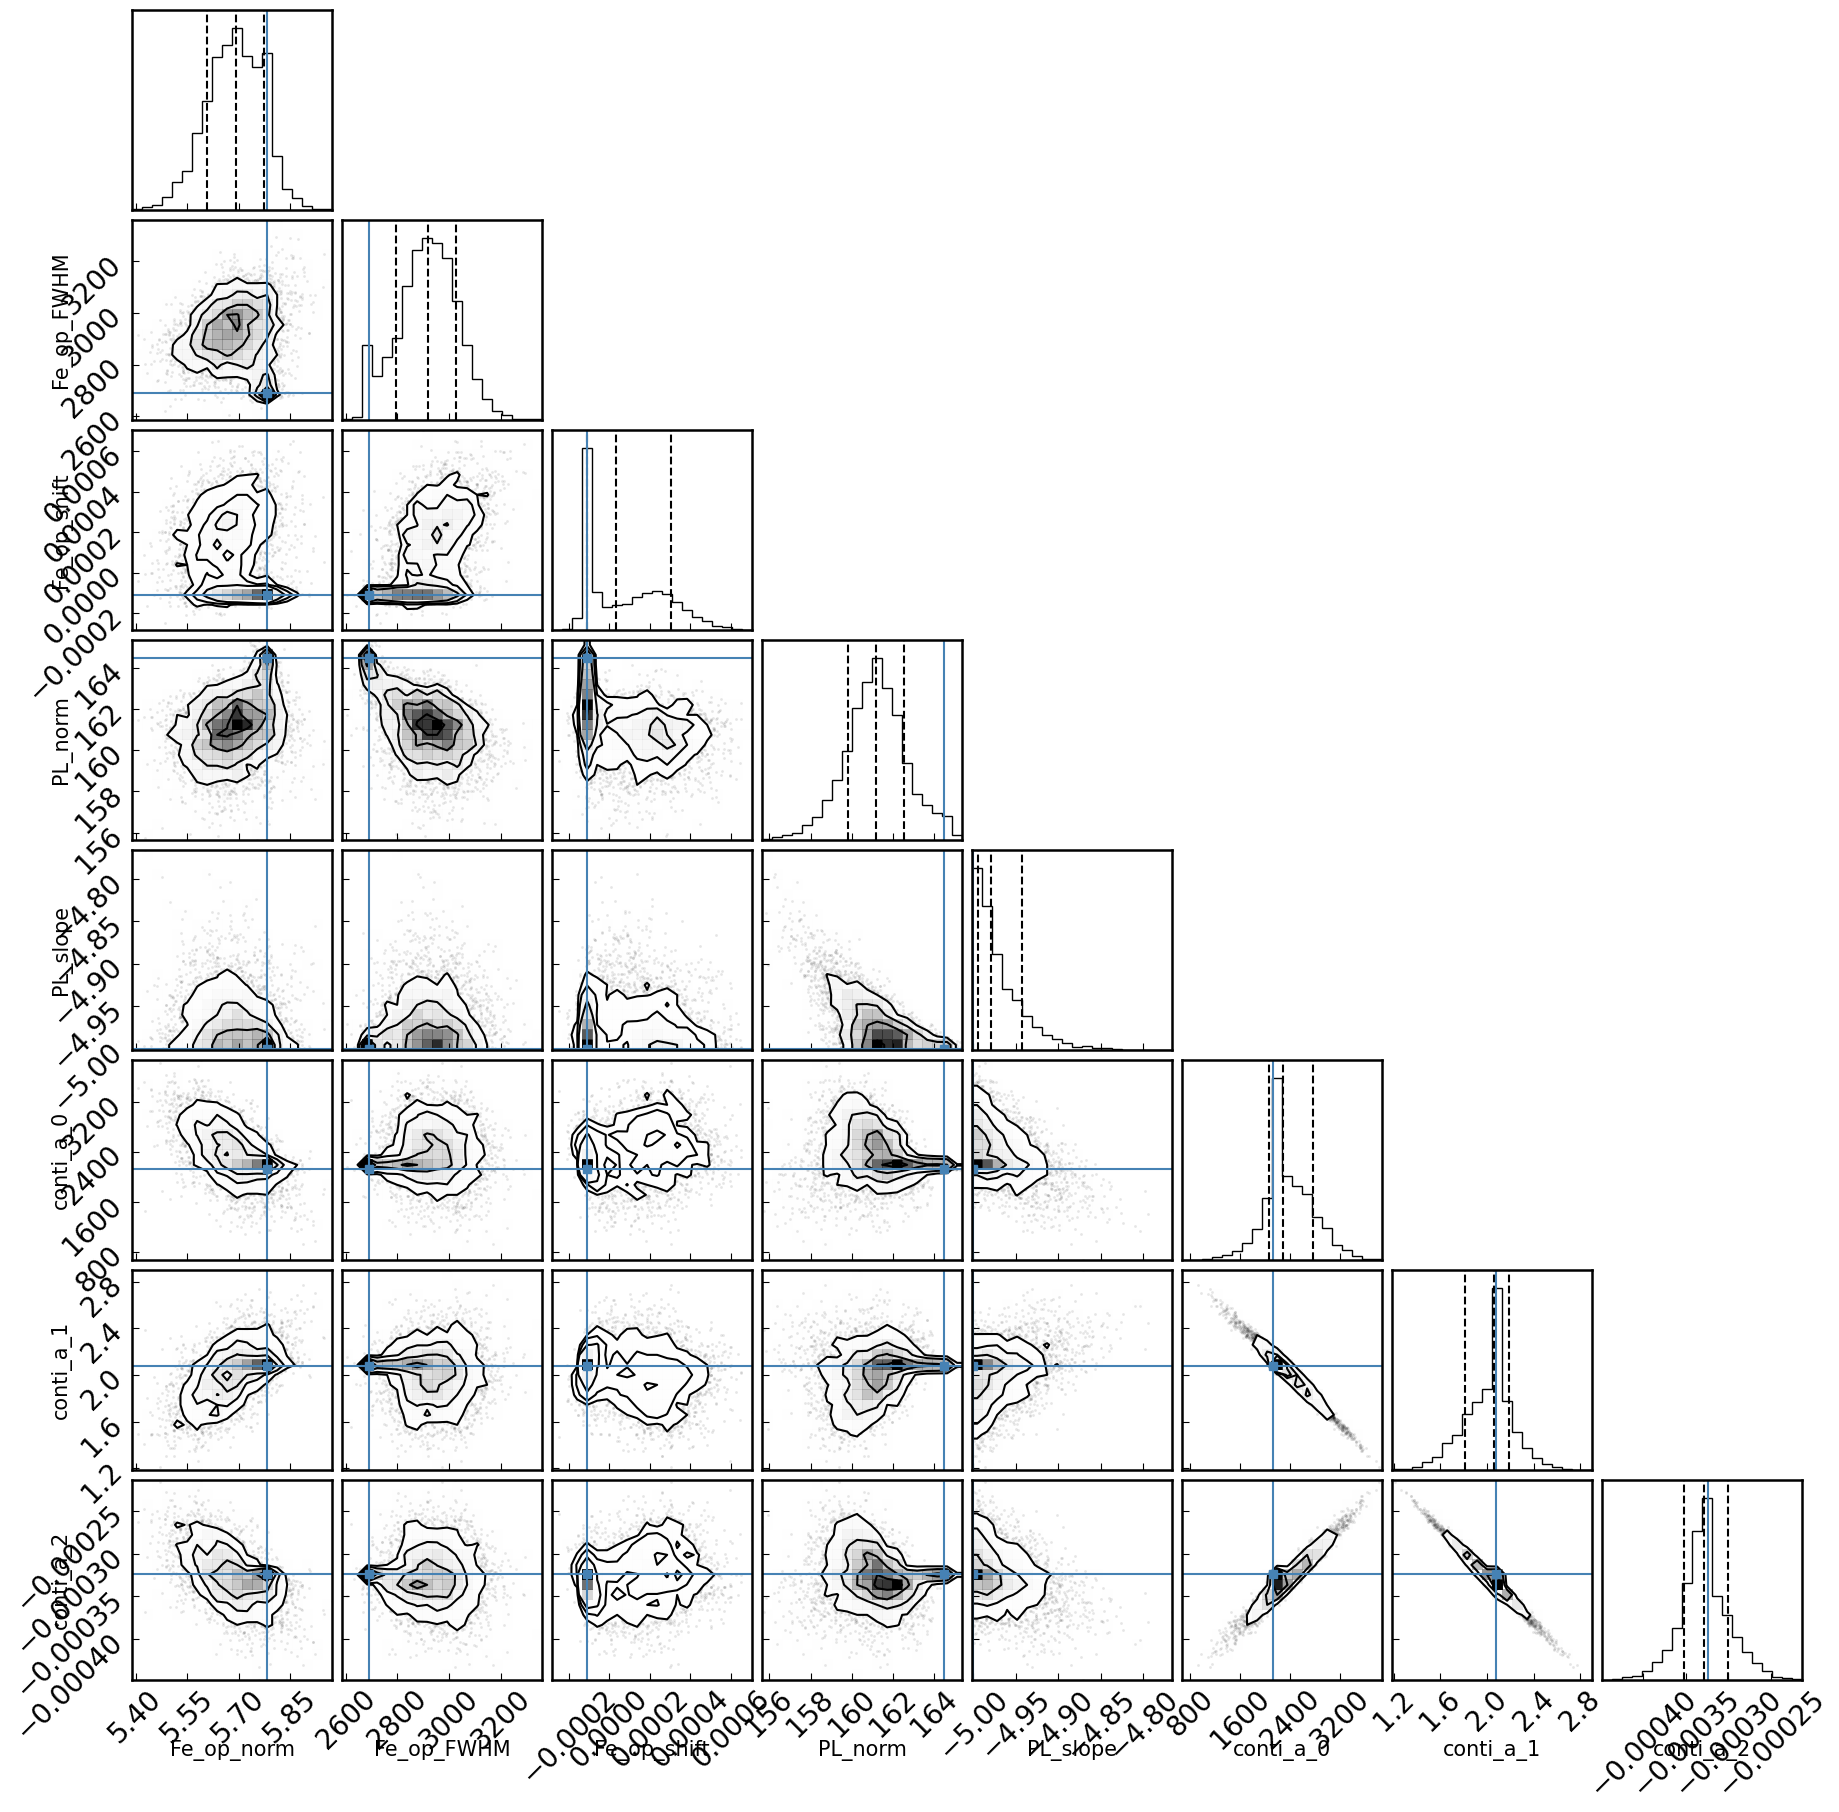

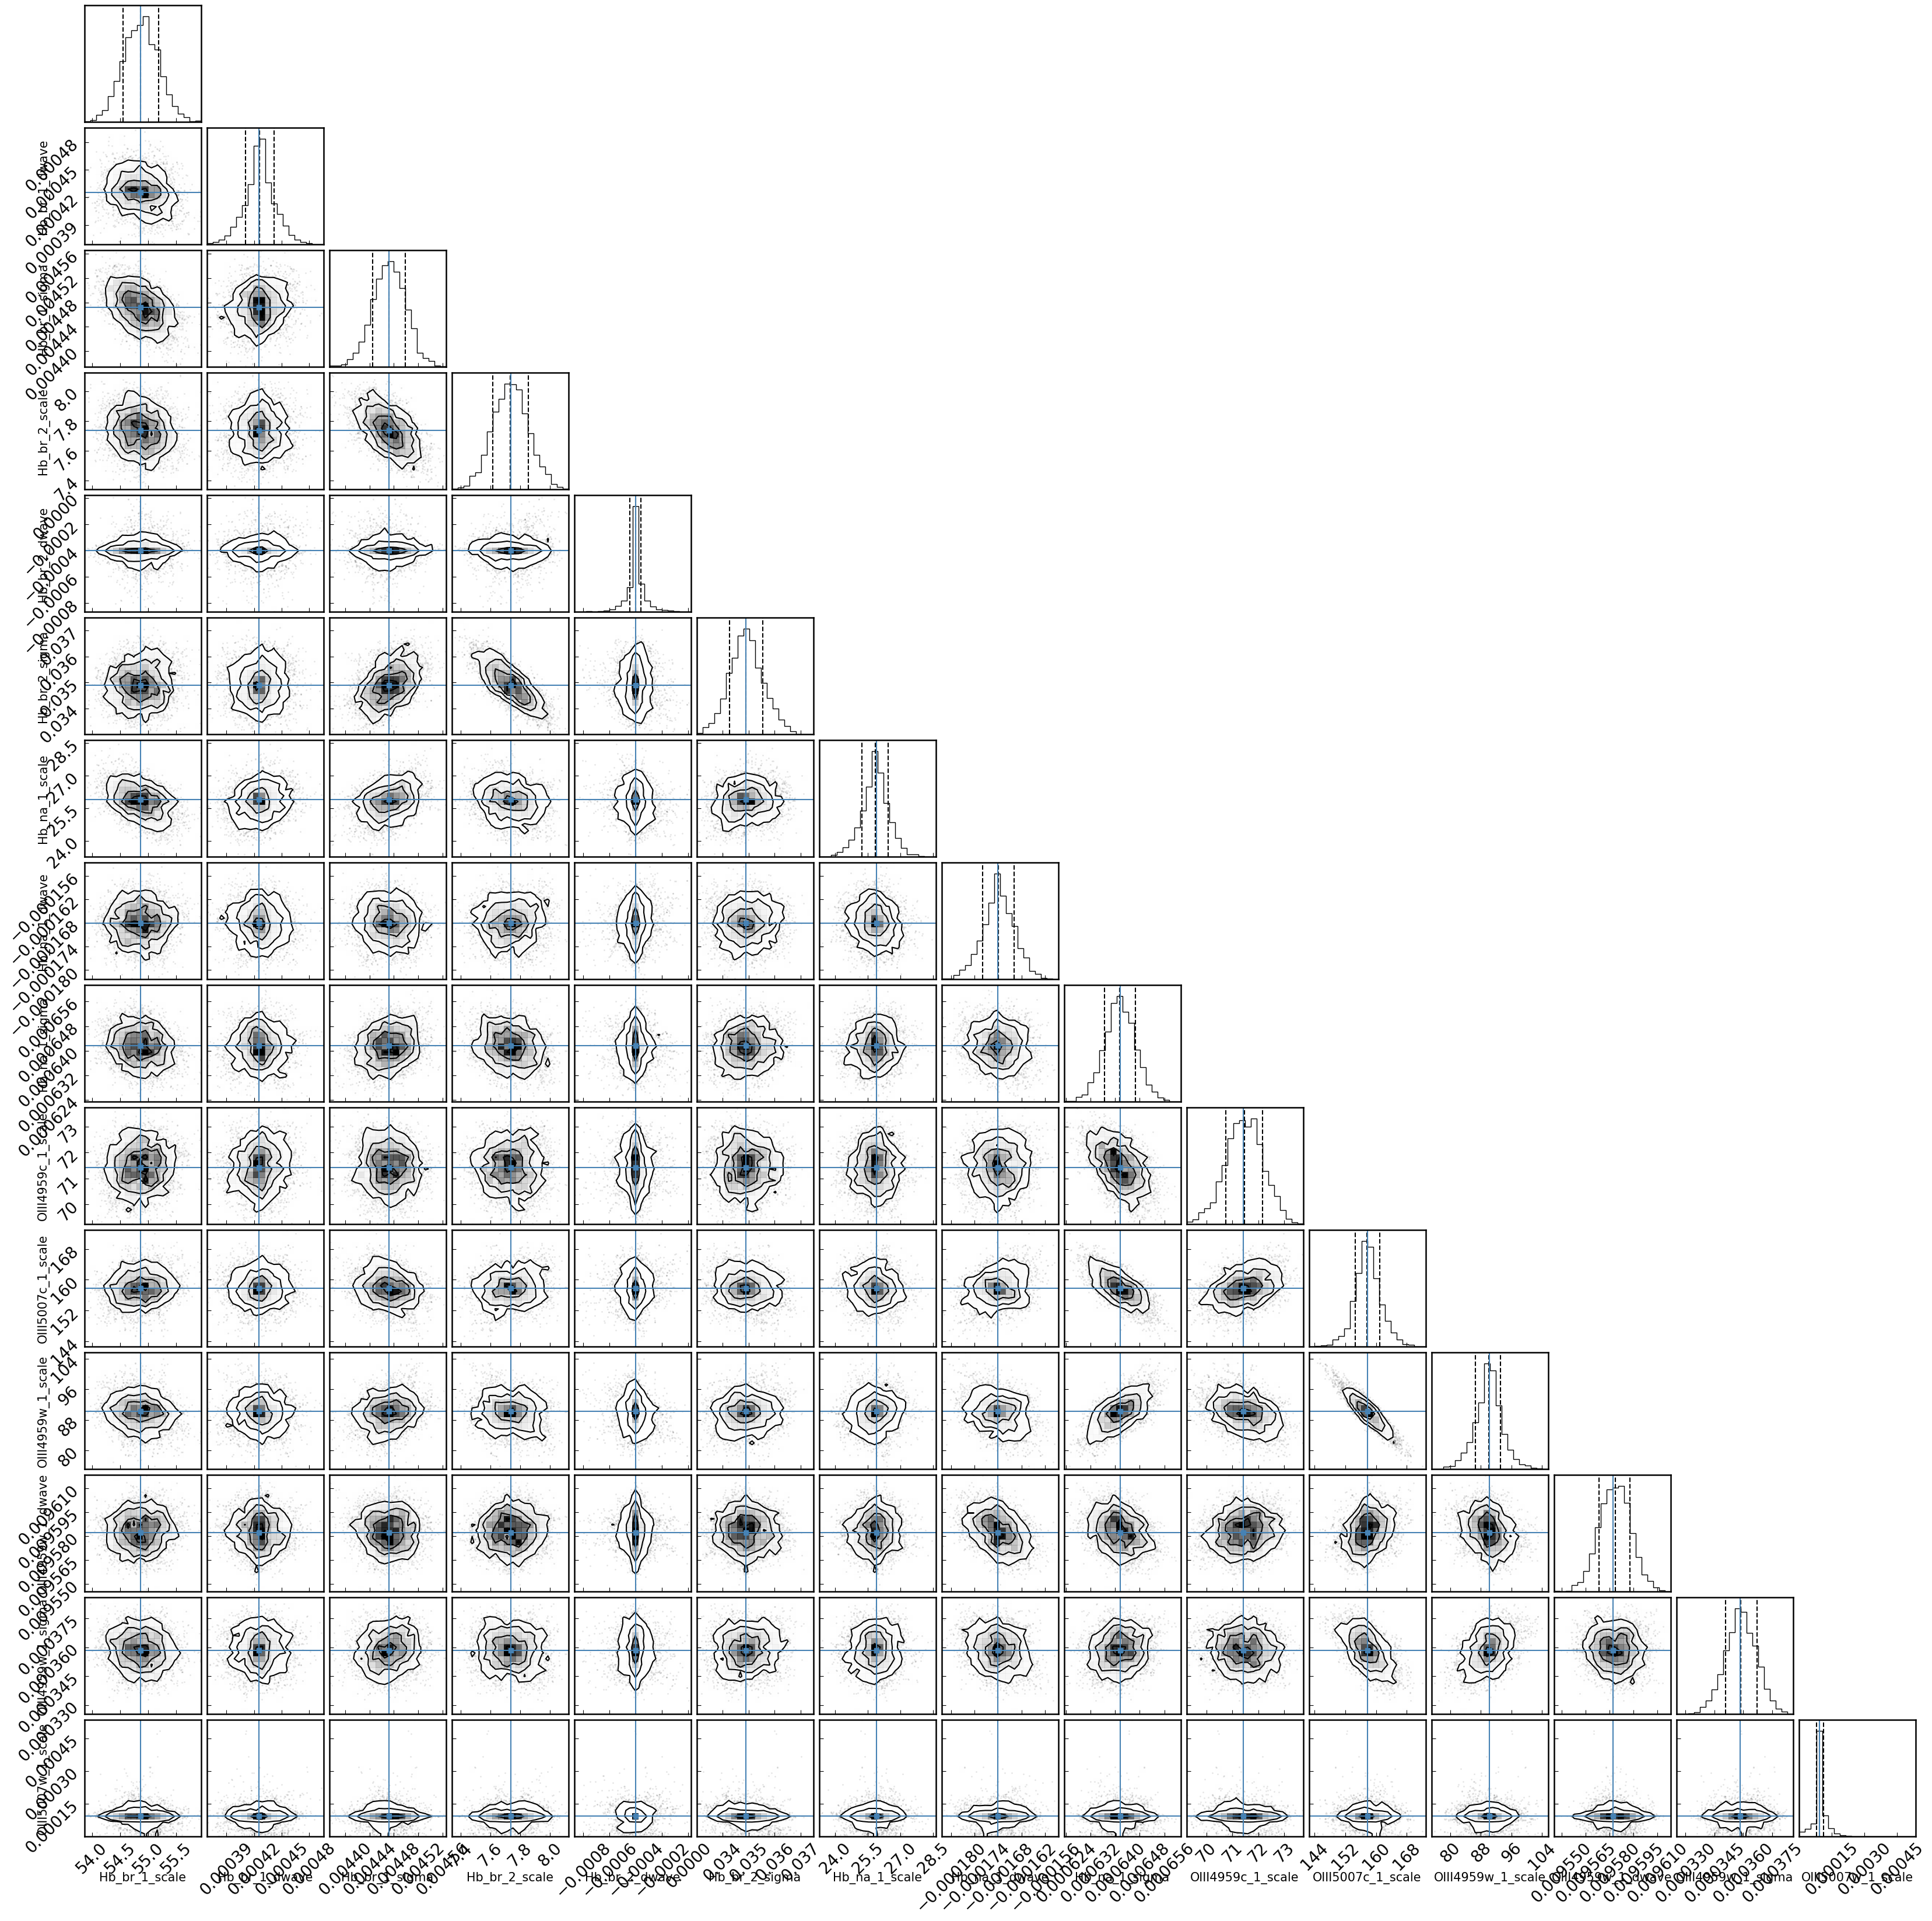

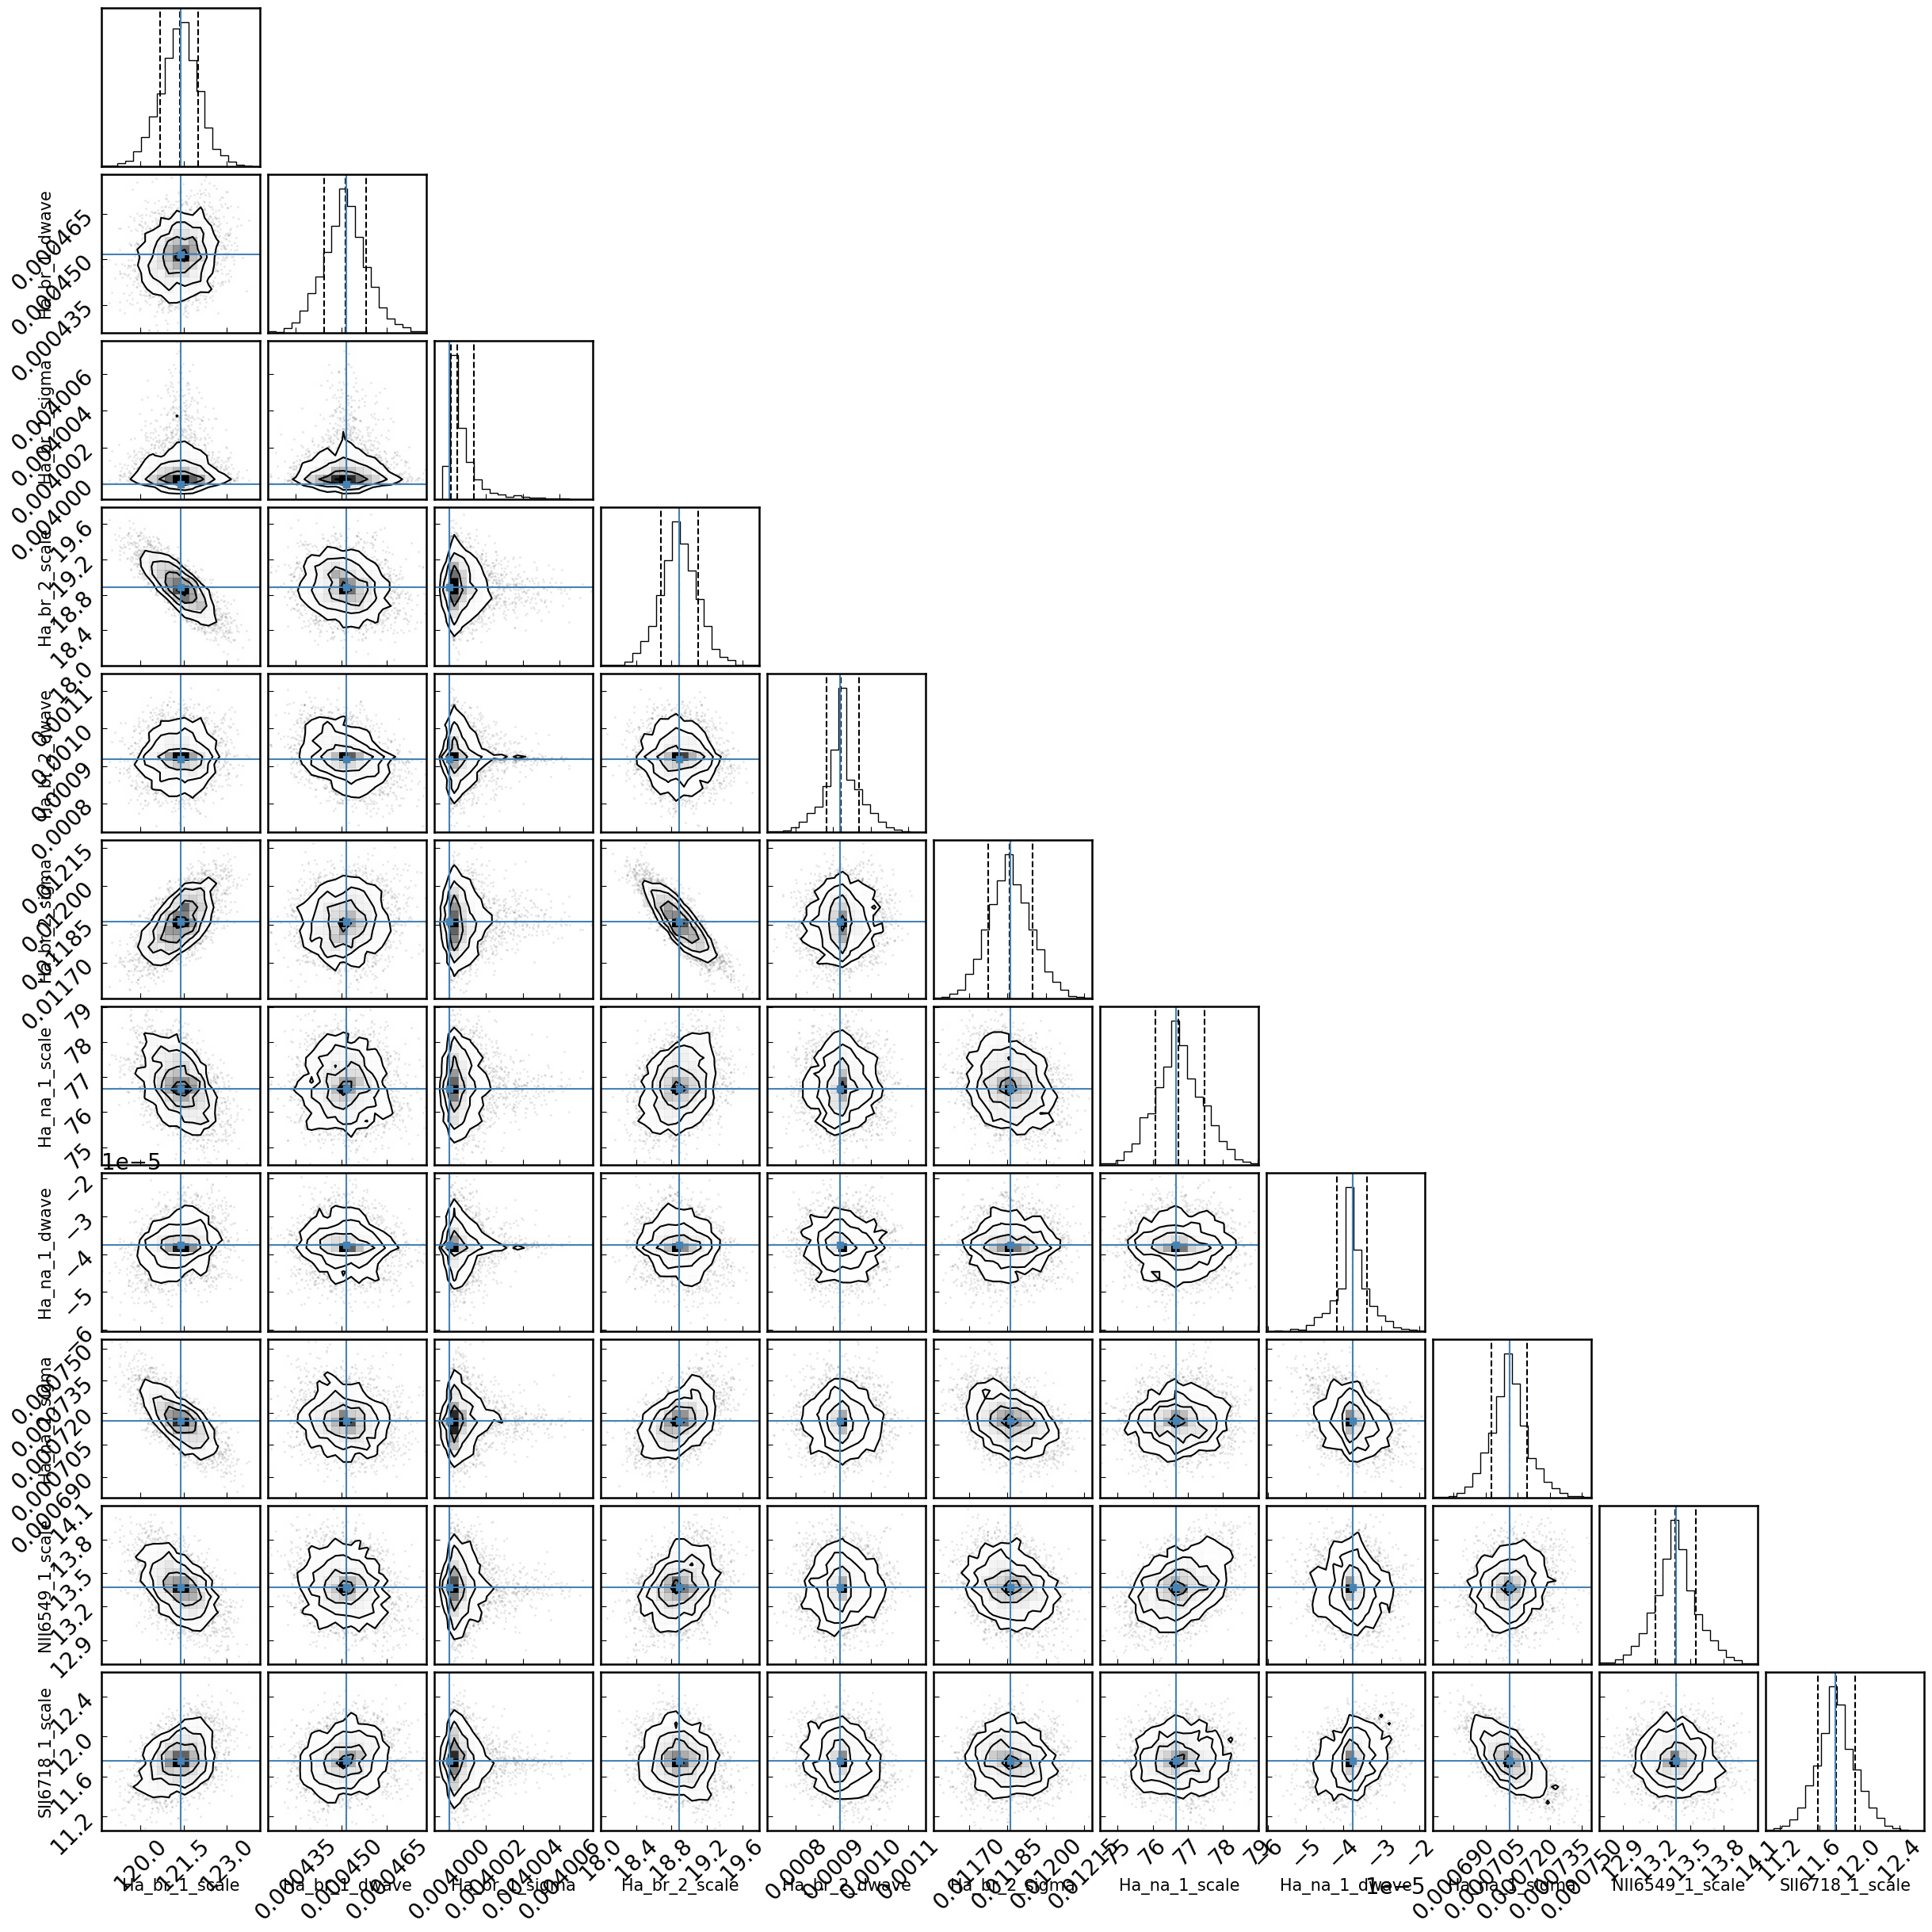

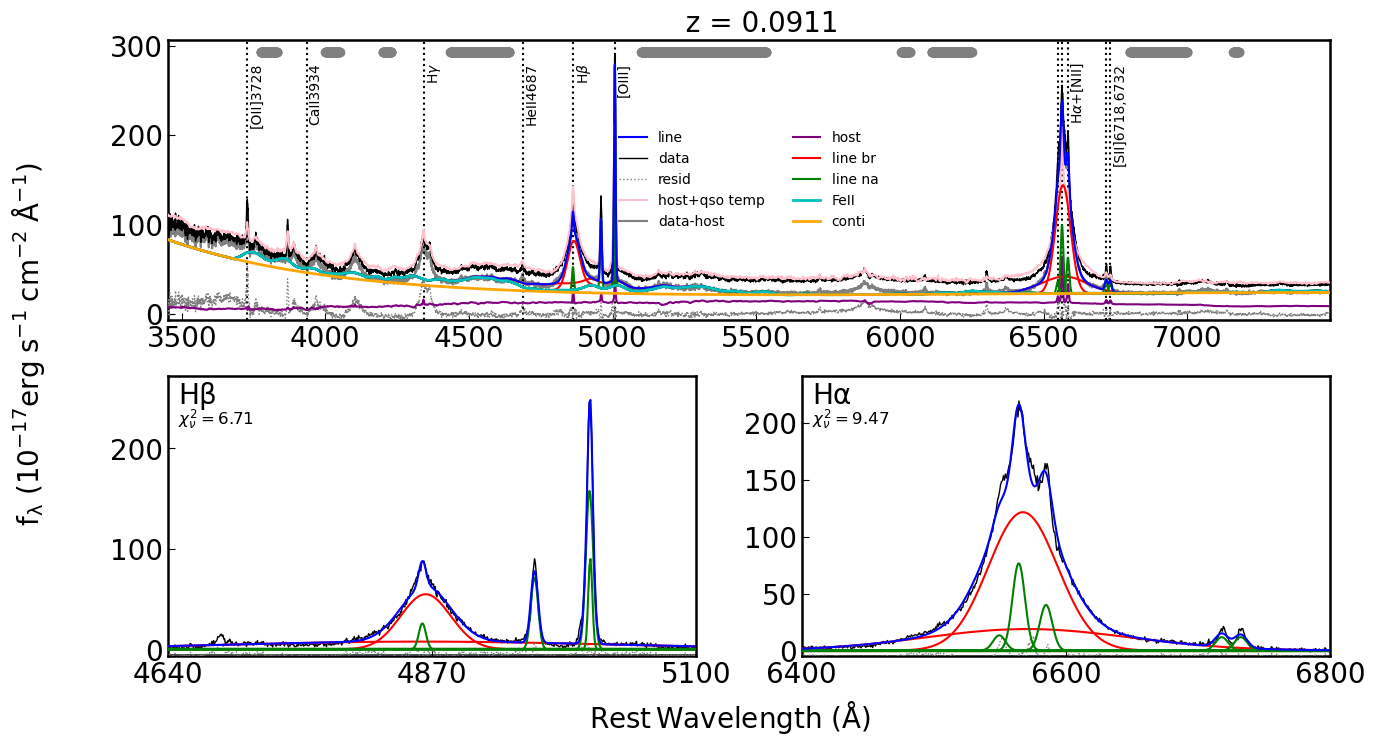

In [15]:
q_mcmc = QSOFit(lam, flux, err, z, path=path_ex)

start = timeit.default_timer()
# Do the fitting
q_mcmc.Fit(name=None, nsmooth=1, deredden=True, reject_badpix=False, wave_range=None, \
           wave_mask=None, decompose_host=True, host_prior=True, decomp_na_mask=True, npca_gal=5, npca_qso=10, qso_type='CZBIN1',
           Fe_uv_op=True, poly=True, rej_abs_conti=False, \
           MCMC=True, epsilon_jitter=0, nburn=10, nsamp=400, nthin=10, linefit=True, save_result=True, \
           plot_fig=True, save_fig=False, plot_corner=True, kwargs_plot={'save_fig_path': '.'}, save_fits_name=None,
           verbose=False)

end = timeit.default_timer()

print(f'Fitting finished in {np.round(end - start, 1)}s')

Broad Ha:
FWHM (km/s) 3090.7
Sigma (km/s) 2209.4
EW (A) 518.3
Peak (A) 6567.6
Area (10^(-17) erg/s/cm^2) 11673.0

Narrow Hb:
FWHM (km/s) 3478.8
Sigma (km/s) 7536.4
EW (A) 263.5
Peak (A) 4865.2
Area (10^(-17) erg/s/cm^2) 6275.1


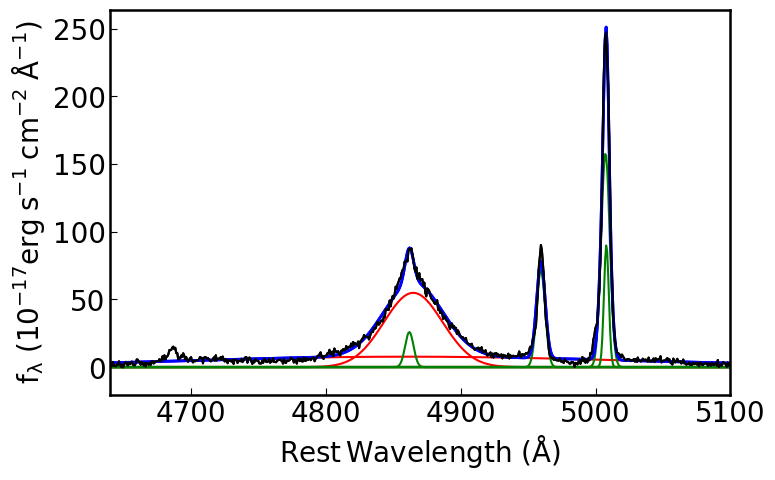

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

if q_mcmc.MCMC:
    gauss_result = q_mcmc.gauss_result[::2]
else:
    gauss_result = q_mcmc.gauss_result

# Plot individual line components
for p in range(int(len(gauss_result) / 3)):
    if q_mcmc.CalFWHM(gauss_result[3 * p + 2]) < 1200:  # < 1200 km/s narrow
        color = 'g'  # narrow
    else:
        color = 'r'  # broad
    ax.plot(q_mcmc.wave, q_mcmc.Onegauss(np.log(q_mcmc.wave), gauss_result[p * 3:(p + 1) * 3]), color=color)

# Plot total line model
ax.plot(q_mcmc.wave, q_mcmc.Manygauss(np.log(q_mcmc.wave), gauss_result), 'b', lw=2)
ax.plot(q_mcmc.wave, q_mcmc.line_flux, 'k')
ax.set_xlim(6400, 6800)
ax.set_xlabel(r'$\rm Rest \, Wavelength$ ($\rm \AA$)', fontsize=20)
ax.set_ylabel(r'$\rm f_{\lambda}$ ($\rm 10^{-17} erg\;s^{-1}\;cm^{-2}\;\AA^{-1}$)', fontsize=20)

ax.plot(q_mcmc.wave, q_mcmc.Manygauss(np.log(q_mcmc.wave), gauss_result), 'b', lw=2)
ax.plot(q_mcmc.wave, q_mcmc.line_flux, 'k')
ax.set_xlim(4640, 5100)
ax.set_xlabel(r'$\rm Rest \, Wavelength$ ($\rm \AA$)', fontsize=20)
ax.set_ylabel(r'$\rm f_{\lambda}$ ($\rm 10^{-17} erg\;s^{-1}\;cm^{-2}\;\AA^{-1}$)', fontsize=20)

"""
Line properties
"""

# The line_prop function is used to calculate the broad line properties
# (defined, by default, as ln sigma > 0.00169 (1200 km/s) )

# OLD WAY: If you want to calculate the paramters of broad Hb
# then find all the broad Hb component, i.e., Hb_br_[1,2,3]_[scale,centerwave,sigma]
# for here q.line_result_name[12:15], q.line_result[12:15] is the broad Hb
# If MCMC=False, this would be:
# fwhm, sigma, ew, peak, area = q.line_prop(q.linelist[6][0], q.line_result[12:15], 'broad')

# NEW WAY: using line_prop_from_name convenience function
fwhm, sigma, ew, peak, area, snr = q_mle.line_prop_from_name('Ha_br', 'broad')

print("Broad Ha:")
print("FWHM (km/s)", np.round(fwhm, 1))
print("Sigma (km/s)", np.round(sigma, 1))
print("EW (A)", np.round(ew, 1))
print("Peak (A)", np.round(peak, 1))
print("Area (10^(-17) erg/s/cm^2)", np.round(area, 1))
print("")

# OLD WAY: If you want to calculate the  the narrow [OIII]5007
# If MCMC=False, this would be:
# the coresponding parameters are  q.line_result_name[21:24], q.line_result[21:24]
# fwhm, sigma, ew, peak, area = q.line_prop(q.linelist[6][0], q.line_result[21:24], 'narrow')

fwhm, sigma, ew, peak, area, snr = q_mcmc.line_prop_from_name('Hb_br', 'broad')

print("Narrow Hb:")
print("FWHM (km/s)", np.round(fwhm, 1))
print("Sigma (km/s)", np.round(sigma, 1))
print("EW (A)", np.round(ew, 1))
print("Peak (A)", np.round(peak, 1))
print("Area (10^(-17) erg/s/cm^2)", np.round(area, 1))

In [17]:
# Empirical coefficients (example values, these should be confirmed with the latest literature)
A = 6.3
B = 2.0
C = 0.5

# Example FWHM of Hα (in km/s) and luminosity of Hα (in erg/s)
fwhm_ha = 3090.7  # Example value
lum_ha = 1e42   # Example value

# Calculate the black hole mass in solar masses
M_BH = 10**A * (fwhm_ha / 1000)**B * (lum_ha / 1e42)**C
print('BH Mass

In [103]:
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

def luminosity_distance(redshift, H0=70, Om0=0.3):
    """
    Calculate the luminosity distance using astropy.
    """
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)
    d_L = cosmo.luminosity_distance(redshift)
    return d_L.to(u.Mpc).value  # Return luminosity distance in Mpc

# Example usage
redshift = 0.0911
lum_distance = luminosity_distance(redshift)
print("Luminosity distance:", lum_distance, "Mpc")

Luminosity distance: 416.82228488548014 Mpc


In [175]:
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import numpy as np

def luminosity_distance(redshift, H0=70, Om0=0.3):
    """
    Calculate the luminosity distance using astropy.
    """
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)
    d_L = cosmo.luminosity_distance(redshift)
    return d_L.to(u.Mpc).value  # Return luminosity distance in Mpc
def luminosity_at_6200(flux_spectrum, wavelength_spectrum, redshift, luminosity_distance):
    """
    Calculate the luminosity at the wavelength closest to 6200 Å.
    """
    # Define wavelength range around 6200 Å
    lambda_6200_range = 100  # Adjust this value as needed based on the width of the range you want to integrate

    # Find indices corresponding to the wavelength range
    idx_min = np.abs(wavelength_spectrum - 6200).argmin()
    idx_max = np.abs(wavelength_spectrum - (6200 + lambda_6200_range)).argmin()

    # Correct flux for redshift
    corrected_flux_spectrum = flux_spectrum * (1 + redshift)

    # Integrate the flux over the wavelength range
    integrated_flux = np.trapz(corrected_flux_spectrum[idx_min:idx_max], wavelength_spectrum[idx_min:idx_max])

    # Calculate luminosity at the wavelength closest to 6200 Å
    luminosity_6200 = 4 * np.pi * (luminosity_distance * u.Mpc).to(u.cm)**2 * integrated_flux * u.erg / u.s

    return luminosity_6200

# Example usage
redshift = 0.091
lum_distance = luminosity_distance(redshift)
flux = q_mle.line_flux + q_mle.f_conti_model  # Combined flux
wavelength = q_mle.wave  # Wavelength array
luminosity = luminosity_at_6200(flux, wavelength, redshift, lum_distance)
print("Luminosity at 6200 Å:", luminosity)

Luminosity at 6200 Å: 5.229902002834757e+58 cm2 erg / s


In [176]:
import numpy as np
from scipy.integrate import simps
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM

def luminosity_distance(redshift, H0=70, Om0=0.3):
    """
    Calculate the luminosity distance using astropy.
    """
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)
    d_L = cosmo.luminosity_distance(redshift)
    return d_L.to(u.Mpc).value  # Return luminosity distance in Mpc

def luminosity_at_wavelength(flux_spectrum, wavelength_spectrum, wavelength_target, redshift, luminosity_distance):
    """
    Calculate the luminosity at a specific wavelength in a spectrum.
    """
    # Define wavelength range around the target wavelength
    lambda_range = 10  # Adjust this value as needed based on the width of the range you want to integrate

    # Find indices corresponding to the wavelength range
    idx_min = np.abs(wavelength_spectrum - wavelength_target).argmin()
    idx_max = np.abs(wavelength_spectrum - (wavelength_target + lambda_range)).argmin()

    # Correct flux for redshift
    corrected_flux_spectrum = flux_spectrum * (1 + redshift)

    # Integrate the flux over the wavelength range using Simpson's rule
    integrated_flux = simps(corrected_flux_spectrum[idx_min:idx_max], wavelength_spectrum[idx_min:idx_max])

    # Calculate luminosity at the target wavelength
    luminosity_target = 4 * np.pi * (luminosity_distance * u.Mpc).to(u.cm)**2 * integrated_flux * u.erg / u.s

    return luminosity_target

# Example usage
redshift = 0.091
lum_distance = luminosity_distance(redshift)
flux_spectrum = q_mle.line_flux + q_mle.f_conti_model  # Combined flux
wavelength_spectrum = q_mle.wave  # Replace ... with corresponding wavelengths
wavelength_target = 6200  # Target wavelength in Å
luminosity = luminosity_at_wavelength(flux_spectrum, wavelength_spectrum, wavelength_target, redshift, lum_distance)
print("Luminosity at", wavelength_target, "Å:", luminosity)


Luminosity at 6200 Å: 4.546734658317749e+57 cm2 erg / s


In [171]:
math.log10(6.721*((5100*5.224195190786205e13)**.65)*(3478.8**2/1000))

16.23692603945012

In [ ]:
math.log10(6.721*((6200*5.224195190786205e13)**.65)*(3764.4**2/1000))

In [49]:
import numpy as np
from scipy.integrate import quad

# Define cosmological parameters (example values)
H0 = 70  # Hubble constant in km/s/Mpc
c = 299792.458  # Speed of light in km/s
Omega_m = 0.3  # Density parameter for matter
Omega_Lambda = 0.7  # Density parameter for cosmological constant

# Redshifts
z_L = 0.091
z_S = 0.5219

# Define the integrands for comoving distance calculation
def integrand(z):
    return 1 / np.sqrt(Omega_m * (1 + z)**3 + Omega_Lambda)

# Calculate the comoving distances
D_L, _ = quad(integrand, 0, z_L)
D_S, _ = quad(integrand, 0, z_S)
D_LS, _ = quad(integrand, z_L, z_S)

# Convert distances from Mpc to meters
D_L *= c / H0 * 1e6
D_S *= c / H0 * 1e6
D_LS *= c / H0 * 1e6

# Mass of the lensing object (example value)
M = 1e39  # in kilograms
G = 6.67*10**-11
# Calculate the Einstein radius
theta_E = np.sqrt(((M*G) / (c**2)) * (D_LS/(D_L * D_S)))

print("Einstein radius:", theta_E, "radians")

Einstein radius: 39573.73854943245 radians


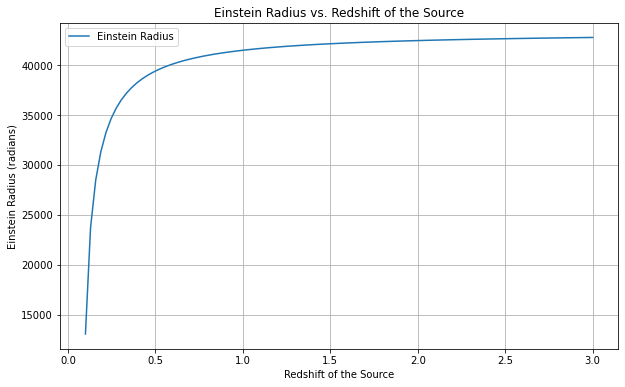

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# Define cosmological parameters (example values)
H0 = 70  # Hubble constant in km/s/Mpc
c = 299792.458  # Speed of light in km/s
Omega_m = 0.3  # Density parameter for matter
Omega_Lambda = 0.7  # Density parameter for cosmological constant

# Function to calculate comoving distance
def comoving_distance(z):
    def integrand(z):
        return 1 / np.sqrt(Omega_m * (1 + z)**3 + Omega_Lambda)
    result, _ = quad(integrand, 0, z)
    return result * c / H0 * 1e6  # Convert from Mpc to meters

# Function to calculate Einstein radius
def einstein_radius(M, z_S, z_L):
    D_L = comoving_distance(z_L)
    D_S = comoving_distance(z_S)
    D_LS = comoving_distance(z_S) - comoving_distance(z_L)
    return np.sqrt(((M*G) / (c**2)) * (D_LS/(D_L * D_S)))

# Define the mass of the lensing object
M = 1e39  # in kilograms

# Redshift range for the source
z_S_range = np.linspace(0.1, 3.0, 100)

# Calculate Einstein radius for each redshift
theta_E_values = []
for z_S in z_S_range:
    theta_E = einstein_radius(M, z_S, z_L)
    theta_E_values.append(theta_E)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(z_S_range, theta_E_values, label='Einstein Radius')
plt.xlabel('Redshift of the Source')
plt.ylabel('Einstein Radius (radians)')
plt.title('Einstein Radius vs. Redshift of the Source')
plt.grid(True)
plt.legend()
plt.show()

In [79]:
pip install lenstronomy

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.6 MB 15.1 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 536 kB 78.3 MB/s            
     |████████████████████████████████| 49 kB 4.4 MB/s             
  Created wheel for lenstronomy: filename=lenstronomy-1.11.7-py3-none-any.whl size=1187400 sha256=0075c853bc3e6ad4e405a7dbbb886f53dc4cd94fad2e71fbb8115848a2789fbb
  Stored in directory: /global/u1/e/edm2158/.cache/pip/wheels/0d/bf/17/7d3fa9141c446c807d29181f07ada7a0442f38dc974311045c
Successfully built lenstronomy
Note: you may need to restart the kernel to use updated packages.


In [65]:
import scipy

def aad(z1, z2, omegaM, omegaL, H0):

    # simple calculator, works only in LambdaCDM
    #return angular diameter distance in Mpc

    c=299792.458
    omegaM=float(omegaM)
    omegaL=float(omegaL)

    K=(H0/c)**2 * (omegaM+omegaL-1.0)
    curvature = (omegaM+omegaL-1.0)
    x = c/H0 * scipy.integrate.quad(integrand, z1, z2, args=(omegaM, omegaL))[0]


    if curvature>0:
        f=1.0/np.sqrt(K)*np.sin(np.sqrt(K)*x)
    elif curvature == 0:
        f=x
    elif curvature < 0:
        f=1.0/np.sqrt(-1.0*K)*np.sinh(np.sqrt(-1.0*K)*x)

    return 1.0 / (1.0+z2) * f

In [66]:
def compute_thetaE(M, z_lens, z_source, Omega_m=0.3, Omega_l=0.7, H0=70):
    '''
    Return the Einstein radius in arsec
    :param M: mass in Solar mass
    :param z_lens:
    :param z_source:
    :return:
    '''
    D_l = aad(0., z_lens, Omega_m, Omega_l, H0)  # in Gpc
    D_s = aad(0., z_source, Omega_m, Omega_l, H0)  # in Gpc
    D_ls = aad(z_lens, z_source, Omega_m, Omega_l, H0)  # in Gpc

    # thetaE = np.sqrt(M / 10**11.09) * np.sqrt((D_l*D_s)/D_ls)
    # print((4 * G * M * M_sun) / c ** 2)
    thetaE = np.sqrt(((4 * G * M * M_sun) / c ** 2) * ((D_ls / (D_l * D_s)) / Mpc)) * rad_to_arcsec
    return thetaE

In [67]:
H0 = 70.
Omega_m = 0.30
Omega_l = 0.70
z_l = 0.209
z_s = 0.558
pc =3.086e16 #in m
Mpc =3.086e22
Gpc = 3.086e+25
c = 3e8 #m/s
rad_to_arcsec = 206265
M_sun = 1.98847e30
G = 6.67408e-11

compute_thetaE(10**12*M_sun, .091, .5219)

TypeError: integrand() takes 1 positional argument but 3 were given

In [68]:
import numpy as np
import scipy.integrate

c = 299792458.0  # Speed of light in m/s

def integrand(z, omegaM, omegaL):
    return 1.0 / np.sqrt(omegaM * (1 + z) ** 3 + omegaL)

def aad(z1, z2, omegaM, omegaL, H0):
    K = (H0 / c) ** 2 * (omegaM + omegaL - 1.0)
    curvature = (omegaM + omegaL - 1.0)
    x = c / H0 * scipy.integrate.quad(integrand, z1, z2, args=(omegaM, omegaL))[0]
    if curvature > 0:
        f = 1.0 / np.sqrt(K) * np.sin(np.sqrt(K) * x)
    elif curvature < 0:
        f = 1.0 / np.sqrt(-K) * np.sinh(np.sqrt(-K) * x)
    else:
        f = x
    return f

def compute_thetaE(M, z_lens, z_source, Omega_m=0.3, Omega_l=0.7, H0=70):
    '''
    Return the Einstein radius in arsec
    :param M: mass in Solar mass
    :param z_lens: redshift of the lens
    :param z_source: redshift of the source
    :param Omega_m: Omega matter
    :param Omega_l: Omega lambda
    :param H0: Hubble constant
    :return:
    '''
    D_l = aad(0., z_lens, Omega_m, Omega_l, H0)  # in Gpc
    D_s = aad(0., z_source, Omega_m, Omega_l, H0)  # in Gpc
    D_ls = aad(z_lens, z_source, Omega_m, Omega_l, H0)  # in Gpc
    
    theta_E = (4 * np.pi * (M * 1.98847e30 / 10**12) * 1.5e11) / (c**2 * D_ls * D_s / D_l)
    return np.degrees(theta_E) * 3600

# Example usage
M_sun = 1.98847e30
theta_E = compute_thetaE(10**12 * M_sun, 0.091, 0.5219)
print("Einstein radius (in arcseconds):", theta_E)

Einstein radius (in arcseconds): 2.1103480620938287e+54


In [36]:
theta_E * (np.pi / 648000)

3.976696543400908e-12

In [37]:
# import the LensModel class #
from lenstronomy.LensModel.lens_model import LensModel

# specify the choice of lens models #
lens_model_list = ['EPL', 'SHEAR']

# setup lens model class with the list of lens models #
lensModel = LensModel(lens_model_list=lens_model_list)

# define parameter values of lens models #
kwargs_spep = {'theta_E': 1.1, 'e1': 0.1, 'e2': 0.1, 'gamma': 2., 'center_x': 0.1, 'center_y': 0}
kwargs_shear = {'gamma1': -0.01, 'gamma2': .03}
kwargs_lens = [kwargs_spep, kwargs_shear]


# image plane coordinate #
theta_ra, theta_dec = 1., .5

# source plane coordinate #
beta_ra, beta_dec = lensModel.ray_shooting(theta_ra, theta_dec, kwargs_lens)
# Fermat potential #
fermat_pot = lensModel.fermat_potential(x_image=theta_ra, y_image=theta_dec, x_source=beta_ra, y_source=beta_dec, kwargs_lens=kwargs_lens)

# Magnification #
mag = lensModel.magnification(theta_ra, theta_dec, kwargs_lens)

In [38]:
# keep the imports and variables from above #
# specify redshifts of deflectors #
redshift_list = [0.5, 0.5, .1]
# specify source redshift #
z_source = 1.5
# setup lens model class with the list of lens models #
lens_model_list_mp = ['EPL', 'SHEAR', 'SIS']
lensModel_mp = LensModel(lens_model_list=lens_model_list_mp, z_source=z_source, lens_redshift_list=redshift_list, multi_plane=True)

kwargs_sis = {'theta_E': 0.1, 'center_x': 1., 'center_y': -0.1}
kwargs_lens_mp = [kwargs_spep, kwargs_shear, kwargs_sis]

# source plane coordinate #
beta_ra, beta_dec = lensModel_mp.ray_shooting(theta_ra, theta_dec, kwargs_lens_mp)

# Magnification #
mag = lensModel_mp.magnification(theta_ra, theta_dec, kwargs_lens_mp)

# arrival time relative to a straight path through (0,0) #
dt = lensModel_mp.arrival_time(theta_ra, theta_dec, kwargs_lens_mp)

In [39]:
import matplotlib.pyplot as plt
# keep the imports and variables from above #
# import the lens equation solver class #
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver

# specifiy the lens model class to deal with #
solver = LensEquationSolver(lensModel)

# solve for image positions provided a lens model and the source position #
theta_ra, theta_dec = solver.image_position_from_source(beta_ra, beta_dec, kwargs_lens)

# the magnification of the point source images #
mag = lensModel.magnification(theta_ra, theta_dec, kwargs_lens)

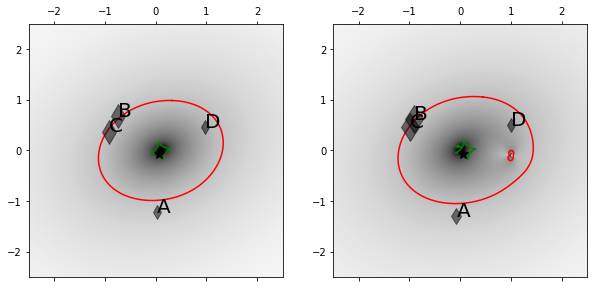

In [17]:
from lenstronomy.Plots import lens_plot
f, axex = plt.subplots(1, 2, figsize=(10, 5), sharex=False, sharey=False)
lens_plot.lens_model_plot(axex[0], lensModel=lensModel, kwargs_lens=kwargs_lens, sourcePos_x=beta_ra, sourcePos_y=beta_dec, point_source=True, with_caustics=True, fast_caustic=True, coord_inverse=False)
lens_plot.lens_model_plot(axex[1], lensModel=lensModel_mp, kwargs_lens=kwargs_lens_mp, sourcePos_x=beta_ra, sourcePos_y=beta_dec, point_source=True, with_caustics=True, fast_caustic=True, coord_inverse=False)
f.show()

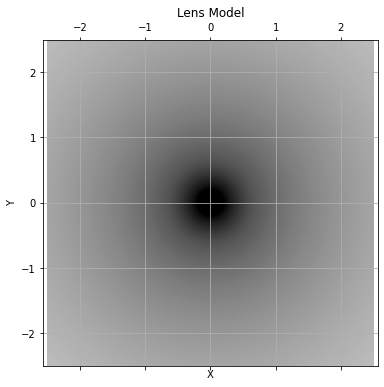

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from lenstronomy.LensModel.lens_model import LensModel

# Define the lensing system parameters
theta_E_rad = 4  # Einstein radius in radians
z_lens = 0.91  # Redshift of the lensing object
z_source = .5219  # Redshift of the source object

# Set up lens model parameters for SIS model
kwargs_sis = {'theta_E': theta_E_rad, 'center_x': 0, 'center_y': 0}
kwargs_lens = [kwargs_sis]

# Initialize LensModel with SIS model
lens_model = LensModel(lens_model_list=['SIS'])

# Plot lens model
f, ax = plt.subplots(1, 1, figsize=(6, 6))
lens_plot.lens_model_plot(ax, lensModel=lens_model, kwargs_lens=kwargs_lens, sourcePos_x=0, sourcePos_y=0, point_source=False, with_caustics=True, fast_caustic=True)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Lens Model')
plt.grid(True)
plt.axis('equal')
plt.show()

IndexError: list index out of range

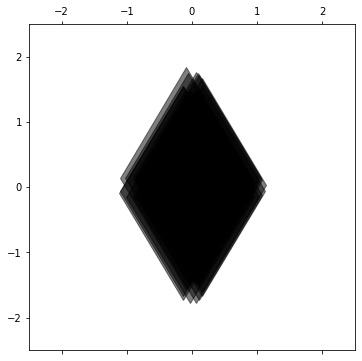

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Plots import lens_plot

# Define the lensing system parameters
M = 1e39  # Mass of the lensing object in kilograms
z_lens = 0.091  # Redshift of the lensing object
z_source = 0.5219  # Redshift of the source object
#theta_E_rad = 1.9393e-7  # Einstein radius in radians

# Convert the Einstein radius to arcseconds
theta_E_arcsec = .16

# Set up lens model parameters for SIS model
kwargs_sis = {'theta_E': theta_E_arcsec, 'center_x': 0, 'center_y': 0}
kwargs_lens = [kwargs_sis]

# Initialize LensModel with SIS model
lens_model = LensModel(lens_model_list=['SIS'])

# Plot caustics
f, ax = plt.subplots(1, 1, figsize=(6, 6))
lens_plot.lens_model_plot(ax, lensModel=lens_model, kwargs_lens=kwargs_lens, point_source=True, with_caustics=True)
plt.xlabel('X (arcsec)')
plt.ylabel('Y (arcsec)')
plt.title('Caustics')
plt.grid(True)
plt.axis('equal')
plt.xlim(-.5e-5, .5e-5)
plt.ylim(-.5e-5, .5e-5)
plt.show()